# LangGraph Lab: Building State-based LLM Workflows

This lab introduces LangGraph and guides students through building stateful graphs that orchestrate LLMs and tools. 

In [1]:
%pip install langchain openai tiktoken faiss-cpu chromadb langchain-openai langchain-tavily langgraph


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "API_KEY_HERE"

OPENAI_MODEL = "gpt-5-mini"

In [3]:
from langgraph.graph import add_messages
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

================================ Human Message =================================

hi!
================================== Ai Message ==================================

hello world


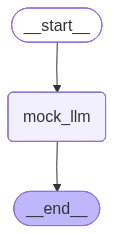

In [4]:
from langgraph.graph import StateGraph, MessagesState, START, END


def mock_llm(state: MessagesState):
    return {"messages": [{"role": "ai", "content": "hello world"}]}

graph = StateGraph(MessagesState)
graph.add_node(mock_llm)
graph.add_edge(START, "mock_llm")
graph.add_edge("mock_llm", END)
graph = graph.compile()

result = graph.invoke({"messages": [{"role": "user", "content": "hi!"}]})

for msg in result["messages"]:
    msg.pretty_print()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Integrating a real LLM node

Below is an example of how to wrap a real LLM call inside a node

In [ ]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage


def openai_node(state: MessagesState):
    llm = ChatOpenAI(model=OPENAI_MODEL, temperature=0.3)
    response = llm.invoke(state["messages"])
    return {"messages": state["messages"] + [{"role": "ai", "content": response.content}]}

# Build and run the graph (small demo)
graph = StateGraph(MessagesState)
graph.add_node("llm_node", openai_node)
graph.add_edge(START, "llm_node")
graph.add_edge("llm_node", END)
graph = graph.compile()

print(type(graph)) # This should look familiar!

response = graph.invoke({"messages": [{"role": "user", "content": "Say hello in a creative way."}]})
for msg in response["messages"]:
    msg.pretty_print()

<class 'langgraph.graph.state.CompiledStateGraph'>


## Adding Tools

In [11]:
from langchain_tavily import TavilySearch

os.environ["TAVILY_API_KEY"] = "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"

tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
    include_answer=True
)

def get_weather(city: str) -> str:
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

tools = [tavily_search_tool, get_weather]


LLM Response: content='' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1377, 'total_tokens': 1402, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-CYhZGZltJxGLdEA6tU7pTQSYAVoDJ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='lc_run--f77e2351-d0b0-4138-b6c1-9a167deef5df-0' tool_calls=[{'name': 'get_weather', 'args': {'city': 'New York City'}, 'id': 'call_5fVJviepBBnEAF1yysTgwfKR', 'type': 'tool_call'}] usage_metadata={'input_tokens': 1377, 'output_tokens': 25, 'total_tokens': 1402, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
{'messages': [HumanMessage(content="

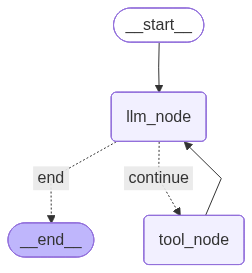

In [ ]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

llm = ChatOpenAI(model=OPENAI_MODEL, temperature=0.3)
llm_with_tools = llm.bind_tools(tools)

def openai_node(state: MessagesState):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": state["messages"] + [response]}

tool_node = ToolNode(tools)

# Define the function that determines whether to continue or not
def router(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there are no tool calls, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

graph = StateGraph(MessagesState)
graph.add_node("llm_node", openai_node)
graph.add_node("tool_node", tool_node)

# Set the entrypoint as `llm_node`
# This means that this node is the first one called
graph.set_entry_point("llm_node")

# We now add a conditional edge
graph.add_conditional_edges(
    # First, we define the start node. We use `llm_node`.
    # This means these are the edges taken after the `llm_node` is called.
    "llm_node",
    # Next, we pass in the function that will determine which node is called next.
    router,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `router`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tool_node",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `llm_node`.
# This means that after `tools` is called, `llm_node` is called next.
graph.add_edge("tool_node", "llm_node")

graph = graph.compile()

response = graph.invoke({"messages": [{"role": "user", "content": "What's the weather in New York City"}]})
for msg in response["messages"]:
    msg.pretty_print()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

Notice this is very similar to an agent in langchain, however we have much more fine grained control in langgraph

this next portion is inspired by this medium article: https://levelup.gitconnected.com/gentle-introduction-to-langgraph-a-step-by-step-tutorial-2b314c967d3c